Question we want to ask:

When is central-place foraging likely to emerge relative to point-to-point?



Variables we are interested in testing for the emergence of CPF: (I am writing all)

1. Sleeping sites distribution
2. Resource type targeted (big/small game)
3. Information-sharing
4. Inter-forager correlation (how spatially correlated foragers are)
5. Intra-forager variation (how successful a forager is)
6. Resource sharing (between families in the same camp)
7. Ability to rest (maybe it can be folded within resource sharing)
8. Ability to defend against predators 



Our hypotheses:

When is CPF better: when temporal, spatial, skill synchrony between foragers is beneficial, when there's a limited availability of sleeping sites, when there are multiple-co depending offspring, when resources are unpredictable and hard to find.

When is P2P better: `**we need to spell out the potential costs of CPF and how to simulate them so that in some instances P2P is better**`




## Define environmental variables


class environment:


##### global variables

n_sleep_site = number of sleeping sites 

n_agents = number of foragers

p_sharing = [0.1, 0.5, 0.9] - probability that an agent shares the harvested with others in their location at the end of the day

n_large_res = number of large resources

n_small_res = number of small resources

pref_previous = y - some factor by which we multiply p_sharing to scale it depending on how many interactions

p_info = [0.1, 0.5, 0.9] - probability that an agent shares information about location of resources with another agent

mov_cost = cost of moving 1km 

min_carrying = minimum amount of energy an agent must have in order to carry a resource instead of consuming it

##### resources 

type = small, large

location = xy coordinates of resource

prob_find = [0.1, 0.5] - probability to find each resource alone, unskilled

prob_harvest = [0.1, 0.5] - probability to harvest each resource alone 

prop_energy = [0.1, 0.5] - proportion of daily requirement satisfied by each resource 


#### sleeping sites

location = xy coordinates of sleeping site

max_people = maximum number of foragers that can reside in a sleeping site



## Agent variables

Agents are a family. E requirement of a family = 7,500kcal

location = xy coordinates of agent

carrying = number of resources agent is carrying

for_speed = [3, 5] foraging speed - how many kilometers an agent can travel in 1h. 

max_carry = maximum amoung of resources that the agent can carry (will be the equivalent of 2 large resources or 4 small ones?)

foraging distance (d) = [5, 10, 20] (km) how far the agent goes to find resources (maximum). small d will mean that they stay close to sleeping site and only find easily available resources like fruits. 

energy (e) : updated each day 

information (i): information for each resource = [0.1, 0.2, ...]. this will update whenever agent finds a resource and when it learns from someone else 

home (p_h): [x,x] tendency to return to sleeping site where they were the previous night (home i_d)

#inter-forager correlation (c): [] length will be equal to num of agents (CP: i'd leave this for stage 2)

p_f = tendency_to_forage: what proportion of days the agent goes foraging (can also be equivalent to what proportion of the members of the family goes foraging (we ignore inter-forager difference in skill?)


each day:

1. agent starts at a sleeping site
2. it forages (8h/day foraging or moving)
    - Agent starts foraging within d
    - if a resource is found
        - Resource is harvested with probability prob_harvested * i (information) of the agent over that resource
    - pay cost of moving depending on how many km
    - if resource is harvested
        - agent carries the resource/consumes the resource depending on whether its energy is higher than min_carrying
    - if agent is carrying less resources than max_carrying & has been foraging less than 8h
        - agent continues foraging

3. end of day: find sleeping site: 
    - pick a new site vs. one from previous day according to p_h
    - if the site from previous day picked, 
        -   pay cost of moving back 
    - else
        -   pay cost of moving to next available sleeping site

4. at sleeping site:
    - count how many foragers at that site 
    - share resources with others according to p_sharing and pref_previous
    - share information with others with some probability (global variable)

## Reporters

Make plots of the following variables over time (over the course of the simulation)

- Mean e of all agents (over time)
- Variance in e of agents

Make plots of the following variables at the end of the simulation: 

- Number of agents alive
- Time til population collapses?

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import copy

# Implementation
## Global variables

In [2]:
# Define probabilities
#P_SHARING = 0.3 # Can be 0.1, 0.5 or 0.9, probability of sharing harvested resources -- NOT USED
#P_INFO = 0.3 # Can be 0.1, 0.5 or 0.9, probability of sharing information about resource locations -- NOT USED
#PREF_PREVIOUS = 1.2 # Increase of sharing harvest/info probability with agents previously shared with 
PREF_PREVIOUS_MOVE = 0.7 # Probability of moving along the same direction as the previous move

# Define costs
MOVE_COST = 80 # Cost of moving 1 km in kcal (Google -- 1 km per kilogram of weight)
CARRY_COST = 10 # Minimum energy in kcal needed to carry 1 unit of resource instead of consuming it on the spot (Around 10 kg -- 10 kcal)

## Classes 

In [3]:
# Define some constants
SMALL_RES = 'small_res'
LARGE_RES = 'large_res'

ENERGY_REQUIREMENT = 7500 # Energy requirement for a day, in kcal

SIM_TIME_STEP = 15 # Time step in minutes, determined by the time the fastest agent can move 1 km

HIGH_PROB = 0.7
MEDIUM_PROB = 0.5
LOW_PROB = 0.3

def distance(loc1: np.ndarray, loc2: np.ndarray):
    """Calculate the Manhattan distance between two locations."""
    return abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])

def decision_making_measure(loc1: np.ndarray, loc2: np.ndarray, res_type):
    """Calculate the Manhattan distance between two locations, weighted by the type of resource.
    
    Distance is "twice as small" for large resources compared to small resources."""
    return (abs(loc1[0] - loc2[0]) + abs(loc1[1] - loc2[1])) * (1 if res_type == SMALL_RES else 1/2)

# Define necessary classes for the game/project/simulation

class SleepSite():
    def __init__(self, site_location: np.ndarray):
        self.location: np.ndarray = site_location
        self.residents: list[Agent] = []

    def daily_reset(self) -> None:
        """Reset the sleep site at the start of the day."""
        # Remove all residents from the sleep site
        self.residents = []
    
    def add_resident(self, agent) -> None:
        """Add an agent to the sleep site."""
        self.residents.append(agent)
    
    def share_harvested_resources(self) -> None:
        """Share the harvested resources between the residents of the sleep site: all residents get the same amount of resources."""
        # If there are no residents, do nothing
        if len(self.residents) == 0:
            return

        # Collect all the food all residents have
        all_resources: list[HarvestedResource] = []

        for resident in self.residents:
            all_resources.extend(resident.give_resources())
        
        # Compute the total prop_energy of all the resources
        total_energy_prop = sum(res.consume() for res in all_resources)
        total_energy = total_energy_prop * ENERGY_REQUIREMENT

        # Divide the total energy between the residents
        energy_per_resident = total_energy / len(self.residents)

        # Add the energy to the residents
        for resident in self.residents:
            resident.gain_energy_from_resources(energy_per_resident)

class HarvestedResource():
    def __init__(self, res_type, prop_energy):
        self.res_type = res_type
        self.res_weight = 1 if self.res_type == SMALL_RES else 2 # Weight of the resource
        self.energy = prop_energy

    def consume(self) -> float:
        """Consume the resource. Returns the energy provided by the resource."""
        return self.energy

class Resource():
    def __init__(self, res_location: np.ndarray):
        self.location: np.ndarray = res_location
        
        # Flip a coin for res_type, p_find, p_harvest, p_energy
        self.res_type = SMALL_RES if random.random() < 0.5 else LARGE_RES
        if self.res_type == SMALL_RES:
            self.p_find = LOW_PROB if random.random() < 0.5 else HIGH_PROB # Probability of finding the resource, unskilled
            self.p_harvest = MEDIUM_PROB if random.random() < 0.5 else HIGH_PROB # Probability of harvesting the resource, alone
            self.prop_energy = 0.1 if random.random() < 0.5 else 0.5 # Proportion of daily energy consuming the resource provides
            self.regrowth_time = 1 # Regrowth time in days.
        elif self.res_type == LARGE_RES:
            self.p_find = MEDIUM_PROB if random.random() < 0.5 else HIGH_PROB # Probability of finding a large resource is higher
            self.p_harvest = LOW_PROB if random.random() < 0.5 else MEDIUM_PROB # Probability of harvesting a large resource is lower
            self.prop_energy = 0.7 if random.random() < 0.5 else 0.9 # Large resource provides more energy
            self.regrowth_time = 2 # Regrowth time in days, large resources take longer to regrow.

        self.regrowing = False # Whether the resource is regrowing
        self.regrowing_days_left = self.regrowth_time # Days left for the resource to regrow
        self.res_weight = 1 if self.res_type == SMALL_RES else 2 # Weight of the resource

    def search_for_resource(self) -> bool:
        """Search for the resource at the location. Returns True if the agent finds the resource, False otherwise."""
        # If the resource is regrowing, the agent cannot find it 
        #TODO: is this correct? Should the agent know the resource is regrowing?
        if self.regrowing:
            return False

        # Roll a dice to see if the agent can find the resource
        if random.random() < self.p_find: #TODO: include the agent's skill level?
            return True
        return False

    def harvest(self) -> HarvestedResource:
        """Harvest the resource at the location. Returns a HarvestedResource object if the agent manages to harvest the resource."""
        # Roll a dice to see if the agent can harvest the resource
        if random.random() < self.p_harvest: # TODO: include the harvesting time -- connected to agent's skill level?
            self.regrowing = True # The resource is regrowing as it was harvested
            return HarvestedResource(self.res_type, self.prop_energy)

    def grow(self) -> None:
        """Grow the resource at the location."""
        if self.regrowing_days_left > 0:
            self.regrowing_days_left -= 1
        else:
            self.regrowing = False
            self.regrowing_days_left = self.regrowth_time


class Agent():
    def __init__(self, agent_id: int, agent_location: np.ndarray, initial_sleep_site: SleepSite):
        self.id = agent_id # Unique identifier
        self.location: np.ndarray = agent_location # Current location
        self.energy = 0 # Energy level

        self.harvested_resources: list[HarvestedResource] = []
        self.capacity = 4 # Maximum number of resource weight the agent can carry
        self.knowledge: list[Resource] = [] # info of resource locations
        self.known_sleep_sites: list[SleepSite] = [initial_sleep_site.location] # info of sleep sites
        # Assumed that the initial location is a sleep site

        self.last_move_direction = None # Last move direction
        self.last_sleep_site_loc = agent_location # Last sleep site

        self.currently_moving = False # Whether the agent is currently moving
        self.time_to_arrive = 0 # Time left to finish current move in minutes

        self.desired_move_location = None # Desired move location
        self.desired_loc_reached = False # Whether the desired location was reached

        # Health reduces by percent of energy requirement not met
        # and increases by percent of surplus energy percentage.
        # If health is below 50, the agent has lower probability of finding/harvesting resources.
        # If health reaches 0, the agent dies.
        self.health = 100 # Health level
        self.dead = False # Dead or alive

        # Flip a coin for move_speed
        self.move_speed = 2 if random.random() < 0.5 else 4 # Speed of the agent in km/h

        # Flip a coin for maximum distance willing to be far from last sleep site
        if random.random() < 1/2:
            self.max_forage_dist = 10
        else:
            self.max_forage_dist = 20 #TODO are these ok values?
        
        # Flip a coin to see whether the agent always returns to the same sleep site
        self.preferred_sleep_site = None if random.random() < 0.5 else initial_sleep_site

        # TODO: Need some sort of memory?

    def daily_reset(self) -> None:
        """Reset the agent's energy level and calculate health level at the start of next day."""
        if self.energy > ENERGY_REQUIREMENT:
            self.health += (self.energy - ENERGY_REQUIREMENT) / ENERGY_REQUIREMENT
            # Health cannot exceed 100
            if self.health > 100:
                self.health = 100

        elif self.energy < ENERGY_REQUIREMENT:
            self.health -= (ENERGY_REQUIREMENT - self.energy) / ENERGY_REQUIREMENT
        
        if self.health < 0:
            self.dead = True
        
        self.energy = 0
        self.last_move_direction = None
        self.last_sleep_site_loc = self.location
    
        self.desired_loc_reached = False
        # With a probability 0.7, choose a new desired location, otherwise, do random foraging walks
        if len(self.knowledge) > 0 and random.random() < 0.7:
            # Sort the knowledge by weighted distance to the agent
            self.knowledge.sort(key=lambda x: decision_making_measure(self.location, x.location, x.res_type))

            # Choose the closest resource location which is inside self.max_forage_dist
            for res in self.knowledge:
                if distance(self.location, res.location) <= self.max_forage_dist:
                    self.desired_move_location = res.location
                    break
        else:
            self.desired_move_location = None


    def daily_foraging_for_time_step(self, current_grid: list[list]) -> None:
        """Continue daily foraging for the next time step."""

        # Check if the agent is currently moving
        if self.currently_moving:
            self.time_to_arrive -= SIM_TIME_STEP

            # If the agent has executed a move, stop and forage the location
            if self.time_to_arrive <= 0:
                self.currently_moving = False
                self.time_to_arrive = 0

                self.forage_location(current_grid)

        # If the agent is not moving, choose the next move and start moving
        else:
            # If the agent has a desired location and it hasn't been reached yet, move towards it
            if self.desired_move_location is not None and not self.desired_loc_reached:
                # Move towards the desired location
                self.move_towards_location(self.desired_move_location)
                
                # Check if the desired location was reached
                if self.location == self.desired_move_location:
                    self.desired_loc_reached = True
            else:
                # Move randomly
                self.move_randomly()
            self.currently_moving = True
            self.time_to_arrive = 60 / self.move_speed

            # Use the time step to move
            self.time_to_arrive -= SIM_TIME_STEP

    def move_towards_location(self, desired_location) -> None:
        """Move towards the desired location."""
        # Calculate the direction to move
        move_direction = desired_location - self.location
        previous_location = copy.deepcopy(self.location)

        # Do one step
        if move_direction[0] == 0:
            # Move along the y-axis if the x-axis is reached
            self.location[1] += np.sign(move_direction[1])
        elif move_direction[1] == 0:
            # Move along the x-axis if the y-axis is reached
            self.location[0] += np.sign(move_direction[0])
        else:
            # Prefer moving along the same direction as the last move
            if self.last_move_direction is not None and random.random() < PREF_PREVIOUS_MOVE:
                # Move along the same direction as the last move
                self.location += self.last_move_direction
            else:
                # Move along the desired direction
                if random.random() < 0.5:
                    # Move along the x-axis
                    self.location[0] += np.sign(move_direction[0])
                else:
                    # Move along the y-axis
                    self.location[1] += np.sign(move_direction[1])

        # Update the last move direction
        self.last_move_direction = self.location - previous_location
 
    def move_randomly(self) -> None:
        """Move randomly, but stay within the max_forage_distance."""
        # Randomly choose a direction to move, prefer moving along the same direction as the last move
        if (
            self.last_move_direction is not None 
            and random.random() < PREF_PREVIOUS_MOVE
            and self.check_if_move_is_allowed(self.last_move_direction)
        ):
            # Move along the same direction as the last move
            self.location += self.last_move_direction
        else:
            previous_location = copy.deepcopy(self.location)

            possible_directions = [np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1])]
            allowed_directions = [pos_dir for pos_dir in possible_directions if self.check_if_move_is_allowed(pos_dir)]
            self.location += random.choice(allowed_directions)

            self.last_move_direction = self.location - previous_location
        # TODO: should the agent be less likely to move in the opposite direction of the last move?  

    def check_if_move_is_allowed(self, move_direction) -> bool:
        """Check whether the move moves the agent too far from the last sleep site."""
        future_location = self.location + move_direction
        if distance(self.last_sleep_site_loc, future_location) > self.max_forage_dist:
            return False
        return True

    def gain_energy_from_resources(self, energy_gained) -> None:
        """Gain energy from the harvested resources."""
        self.energy += energy_gained
     
    def forage_location(self, grid: list[list]):
        """Forage the current location."""
        # Check if there's a sleep site at the location. If there is, save it in the known_sleep_sites
        if grid[self.location[0]][self.location[1]] is not None:
            if isinstance(grid[self.location[0]][self.location[1]], SleepSite):
                self.known_sleep_sites.append(grid[self.location[0]][self.location[1]])

        # Check if there's a resource at the location. 
        if grid[self.location[0]][self.location[1]] is not None:
            if isinstance(grid[self.location[0]][self.location[1]], Resource):
                resource : Resource = grid[self.location[0]][self.location[1]]
                # Check if the agent can find the resource
                if resource.search_for_resource():
                    # Add the knowledge of the resource to the agent
                    self.knowledge.append(resource)
                    # Try to harvest the resource
                    harvested_res = resource.harvest()
                    if harvested_res is not None:
                        self.harvested_resources.append(harvested_res)

    def give_resources(self) -> list[HarvestedResource]:
        """Give out all harvested resources."""
        all_harvested_resources = self.harvested_resources

        # Remove the resources from the agent
        self.harvested_resources = []
        return all_harvested_resources
    
    def go_to_sleep_site(self):
        """Go to a sleep site."""
        # If the agent has a preferred sleep site, go there
        if self.preferred_sleep_site is not None:
            self.location = self.preferred_sleep_site.location
        else:
            # Choose the closest known sleep site
            closest_known_sleep_site = min(
                self.known_sleep_sites, key=lambda x: distance(self.location, x.location)
            )
            self.location = closest_known_sleep_site.location
            # Add the agent to the sleep site as a resident
            closest_known_sleep_site.add_resident(self)


**Some General TODOs/Questions**
- harvesting or foraging is not taking any time at the moment -- it's instant.
- agent skill is not taken into account.
- One can think that all both of the above are taken into account when choosing agent walking speed. That it encorporates all of those.
- No sharing of knowledge about resource locations for now.
- Energy spent on moving is not taken into account, including the moving to a sleeping site at the end of the day

## Simulator 

In [5]:
# Define the game simulator

class Simulator():
    def __init__(
            self,
            grid_size: int,
            n_agents: int,
            n_resources: int,
            n_sleep_sites: int,

    ):
        self.grid = [[None for x in range(grid_size)] for y in range(grid_size)]
        self.grid_size = grid_size

        self.agents: list[Agent] = []
        self.resources: list[Resource] = []
        self.sleep_sites: list[SleepSite] = []

        self.create_resources(n_resources)
        self.create_sleep_sites(n_sleep_sites)
        self.create_agents(n_agents)
        

    def create_agents(self, n_agents: int) -> None:
        """Create n_agents number of agents."""
        for i in range(n_agents):
            # For now, all agents start at the same location, the sleep site in the middle of the grid 
            agent_location = np.array([self.grid_size//2, self.grid_size//2])
            self.agents.append(Agent(i, agent_location, self.grid[agent_location[0]][agent_location[1]]))

    def create_resources(self, n_resources: int) -> None:
        """Create resources in the grid."""
        for i in range(n_resources):

            res_loc = np.array([random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)])
            while self.grid[res_loc[0]][res_loc[1]] is not None:
                res_loc = np.array([random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)])
            
            self.grid[res_loc[0]][res_loc[1]] = Resource(res_loc)
            self.resources.append(self.grid[res_loc[0]][res_loc[1]])

    def create_sleep_sites(self, n_sleep_sites) -> None:
        """Create sleep sites in the grid."""
        # Create the initial sleep site in the middle of the grid
        self.grid[self.grid_size//2][self.grid_size//2] = SleepSite(np.array([self.grid_size//2, self.grid_size//2]))
        self.sleep_sites.append(self.grid[self.grid_size//2][self.grid_size//2])

        # Create the rest of the sleep sites
        for i in range(n_sleep_sites - 1):
            site_loc = np.array([random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)])
            while self.grid[site_loc[0]][site_loc[1]] is not None:
                site_loc = np.array([random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1)])
            self.grid[site_loc[0]][site_loc[1]] = SleepSite(site_loc)
            self.sleep_sites.append(self.grid[site_loc[0]][site_loc[1]])

    def daily_reset(self) -> None:
        """Reset the game at the start of the day."""
        # Reset all the sleep sites
        for site in self.sleep_sites:
            site.daily_reset()
        
        # Reset all the agents
        for agent in self.agents:
            agent.daily_reset()
        
        # Let the resources grow
        for res in self.resources:
            res.grow()

    def plot_current_state(self) -> None:
        """Plot the current state of the game."""
        # Scale figure size with grid size
        figure_size = max(6, 4 * (self.grid_size / 10))

        # Plot the grid with resources and sleep sites
        fig, ax = plt.subplots(figsize=(figure_size, figure_size))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if isinstance(self.grid[i][j], Resource):
                    resource = self.grid[i][j]
                    if resource.res_type == SMALL_RES:
                        ax.scatter(i, j, color='green', marker='o', s=50)
                    elif resource.res_type == LARGE_RES:
                        ax.scatter(i, j, color='green', marker='o', s=100)
                elif isinstance(self.grid[i][j], SleepSite):
                    ax.scatter(i, j, color='blue', marker='s')
        
        # Plot the agents
        for agent in self.agents:
            ax.scatter(agent.location[0], agent.location[1], color='red', marker='x')
        
        # Plot the boundaries of the grid
        ax.set_xlim(-1, self.grid_size)
        ax.set_ylim(-1, self.grid_size)
        
        # Plot the grid lines
        ax.set_xticks(range(self.grid_size))
        ax.set_yticks(range(self.grid_size))
        ax.grid(True)
        
        # Plot legend
        ax.plot([], [], 'go', label='Resource')
        ax.plot([], [], 'bs', label='Sleep site')
        ax.plot([], [], 'rx', label='Agent')
        ax.legend()

        plt.show()

## Running it

Number of locations: 400
Number of agents: 1
Number of resources: 40
Number of sleep sites: 20


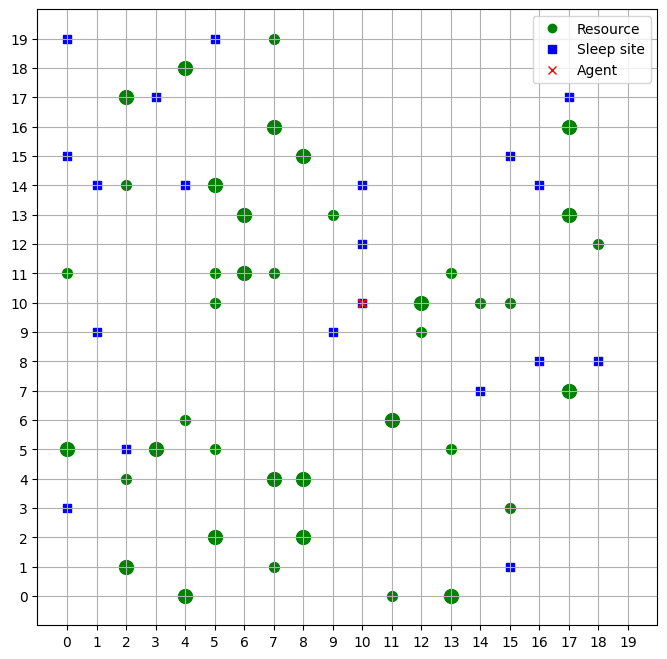

In [6]:
# Define the playing field: let it be a 20x20 grid -- 400 positions
CHOSEN_GRID_SIZE = 20
N_LOCATIONS = CHOSEN_GRID_SIZE * CHOSEN_GRID_SIZE
print("Number of locations:", N_LOCATIONS)

# Define the global variables
N_AGENTS = 1
N_RESOURCES = int(N_LOCATIONS / 10)
# N_LARGE_RES = N_LOCATIONS / 40 # Number of large resources -- NOT USED (DONE RANDOMLY)
# N_SMALL_RES = N_LARGE_RES * 4 # Four times as many as large resources -- NOT USED (DONE RANDOMLY)
N_SLEEP_SITES = int(N_LOCATIONS / 20)
print("Number of agents:", N_AGENTS)
print("Number of resources:", N_RESOURCES)
print("Number of sleep sites:", N_SLEEP_SITES)

# Initialize the simulator
sim = Simulator(
    grid_size=CHOSEN_GRID_SIZE,
    n_agents=N_AGENTS,
    n_resources=N_RESOURCES,
    n_sleep_sites=N_SLEEP_SITES
)

# Plot the initial state
sim.plot_current_state()